In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
import xgboost as xgb
import matplotlib
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import tensorflow as tf
import imblearn
from sklearn.model_selection import train_test_split
import collections
from sklearn.metrics import roc_curve, auc

In [2]:
date='16Mar2021'
dir_name='/preprocessing/200PU_2806'
workdir=os.getcwd()
files_dir='/data_cms_upgrade/hakimi'
os.makedirs(workdir+dir_name, exist_ok=True)
data_dir=workdir+dir_name
signal='elec'
bkg = 'pions'
savedir = workdir + '/moo/'+ bkg + '/'
os.makedirs(savedir, exist_ok=True)

In [3]:
bkg

'pions'

In [4]:
%%time
columns=['genpart_exeta',
         'genpart_pt',
 'cl3d_pt',
 'cl3d_eta',
 'cl3d_showerlength',
 'cl3d_coreshowerlength',
 'cl3d_firstlayer',
 'cl3d_maxlayer',
 'cl3d_seetot',
 'cl3d_seemax',
 'cl3d_spptot',
 'cl3d_sppmax',
 'cl3d_szz',
 'cl3d_srrtot',
 'cl3d_srrmax',
 'cl3d_srrmean',
 'cl3d_emaxe',
 'cl3d_hoe',
 'cl3d_meanz',
 'cl3d_layer10',
 'cl3d_layer50',
 'cl3d_layer90',
 'cl3d_ntc67',
 'cl3d_ntc90',
 'layer',
 'sample',
  'matches',
         
        ]


df_sig= pd.read_csv(data_dir+'/{}.csv'.format(signal), usecols=columns, low_memory=True)
if bkg == 'QCD':
    columns =['event', 'genjet_n', 'genjet_energy', 'genjet_pt', 'genjet_eta',
       'genjet_phi', 'cl3d_pt', 'cl3d_energy', 'cl3d_eta',
       'cl3d_phi', 
       'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer',
       'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot',
       'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean',
       'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
       'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'layer', 'deta', 'dphi',
       'deltar', 'matches',]
elif bkg == 'PU':
    columns = ['event', 'cl3d_pt', 'cl3d_energy', 'cl3d_eta', 'cl3d_phi', 
       'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer',
       'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot',
       'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean',
       'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
       'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'layer',]

df_bkg= pd.read_csv(data_dir+'/{}.csv'.format(bkg), usecols=columns, low_memory=True)
df_bkg['sample']=bkg

print('done')

done
CPU times: user 6.52 s, sys: 585 ms, total: 7.11 s
Wall time: 7.13 s


In [5]:
"""df['genpart_exeta'][df['sample']=='PU']=0
df['genpart_pt'][df['sample']=='PU']=0
df['matches'][df['sample']=='PU']=0"""

"df['genpart_exeta'][df['sample']=='PU']=0\ndf['genpart_pt'][df['sample']=='PU']=0\ndf['matches'][df['sample']=='PU']=0"

# Config

In [6]:
genptcut=20
cl3dptcut=5
PU_cut = 20
etamin=1.6
etamax=2.9
#bkg='QCD' # 'pions' or 'PU'
standardize = "_unstandardized"
feature_set=16 # 1: baseline 4: minimal, 10-13 + new vars (12 -> PU 13-> pions)
opti=False
res_dir=workdir+'/res/res_pt{}_vs{}_featset{}{}'.format(genptcut, bkg, feature_set, standardize)
os.makedirs(res_dir, exist_ok=True)

In [7]:
from collections import Counter
count=Counter

In [8]:
%%time
df_sig['abseta']=np.abs(df_sig['cl3d_eta'])
df_bkg['abseta']=np.abs(df_bkg['cl3d_eta'])
sel = ((np.abs(df_sig['genpart_exeta'])>etamin) & (np.abs(df_sig['genpart_exeta'])<etamax )
       & (df_sig['genpart_pt']>genptcut)&  (df_sig['cl3d_pt']>cl3dptcut) 
       &(df_sig['abseta']>etamin) & (df_sig['abseta']<etamax ))
df_sig_cut=df_sig[sel]
df_sig_cut.dropna(inplace=True)
if bkg == 'QCD':
    sel = ((np.abs(df_bkg['cl3d_eta'])>etamin) & (np.abs(df_bkg['cl3d_eta'])<etamax )&(df_bkg['cl3d_pt']>cl3dptcut))
if bkg == 'pions':
    sel =  ((np.abs(df_bkg['genpart_exeta'])>etamin) & (np.abs(df_bkg['genpart_exeta'])<etamax )
       & (df_bkg['genpart_pt']>genptcut)&  (df_bkg['cl3d_pt']>cl3dptcut) 
       &(df_bkg['abseta']>etamin) & (df_bkg['abseta']<etamax ))
if bkg == 'PU':
    sel = ((np.abs(df_bkg['cl3d_eta'])>etamin) & (np.abs(df_bkg['cl3d_eta'])<etamax )&(df_bkg['cl3d_pt']>PU_cut))
df_bkg_cut=df_bkg[sel]
df_bkg_cut.dropna(inplace=True)
df_cut= df_sig_cut.append(df_bkg_cut)
print(count(df_cut['sample']))

Counter({'elec': 207350, 'pions': 6756})
CPU times: user 315 ms, sys: 93.9 ms, total: 408 ms
Wall time: 408 ms


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
%%time
#cut
algo_cut={}

def tolist(x):
    x.test=x.layer[1:-1].split(',')
    return x.test



#cut on cl3deta
df_cut['abseta']=np.abs(df_cut['cl3d_eta'])
sel=(df_cut['abseta']>etamin) & (df_cut['abseta']<etamax)
df_cut=df_cut[sel]
print('cl3d eta cut:', len(df_cut), len(df_cut[df_cut['sample']=='elec']))
#print('PU: ', len(df_cut[df_cut['sample']=='PU']))
#layer_pt preproc
df_cut['layer_pt']=df_cut.apply(tolist, axis=1)
df_cut.drop('layer', axis=1, inplace=True)
print("done")
def layering (x):
    return float(x.layer_pt[n])

##besoin de créer une variable par layer?
algo_layer={}
n_layers=len(df_cut['layer_pt'].iloc[0])
#print(n_layers)
layer_columns=[]

for n in range(n_layers):
    print('layering: {}/{}\r'.format(n+1,n_layers),end='', flush=True)
    df_cut['layer_{}'.format(n)]=df_cut.apply(layering, axis=1)
    layer_columns.append('layer_{}'.format(n))
print("done layering")



cl3d eta cut: 214106 207350
done
done layering36
CPU times: user 2min 48s, sys: 7.22 s, total: 2min 55s
Wall time: 2min 55s


In [10]:
Counter(df_cut['sample'])

Counter({'elec': 207350, 'pions': 6756})

In [11]:
# build new vars

#abseta
#df_cut['abseta']=np.abs(df_cut['cl3d_eta'])

#variance
df_cut['varee']=df_cut['cl3d_seetot']**2
df_cut['varpp']=df_cut['cl3d_spptot']**2
df_cut['varzz']=df_cut['cl3d_szz']**2
df_cut['varrr']=df_cut['cl3d_srrtot']**2

#EoT: pt(Ecal)/pt(Tot)
nLayerEcal= 14
sumE=0

sumT=0
for i in range(n_layers):
    #print('Totlayer_{}'.format(i))
    sumT+=df_cut['layer_{}'.format(i)]
    
    
for i in range(1,nLayerEcal+1):
    #print('Ecal layer_{}'.format(i))
    sumE+=df_cut['layer_{}'.format(i)]
df_cut['EoT']=sumE/sumT

#fraction of pt in first x  layers and last x layers
maxfirst = 5
maxlast=10

for n in range(1,maxfirst+1):
    Sum=0
    for i in range(1,n+1):
        Sum+=df_cut['layer_{}'.format(i)]
    df_cut['first_{}'.format(n)]= Sum/sumT
    
for n in range(1,maxlast):
    Sum=0
    #print(n, ' layers')
    for i in range(n_layers - n, n_layers):
        #print(n,i)
        Sum+=df_cut['layer_{}'.format(i)]
    #print('last_{}'.format(n), sum/sumT)
    df_cut['last_{}'.format(n)]= Sum/sumT
    
    

for n in range(1,maxfirst+1):
    Sum=0
    for i in range(1,n+1):
        #print('layer_{}'.format(nLayerEcal+i))
        Sum+=df_cut['layer_{}'.format(nLayerEcal+i)]
    df_cut['firstHcal_{}'.format(n)]= Sum/sumT
    
    
# Emaxx : pt in x layers around Elec max layer (5)
maxpos=5

#print('emax_1')
Sum=0
Sum+=df_cut['layer_{}'.format(maxpos)]
df_cut['Emax_1']=Sum/sumT
 
#print('emax_2L')
Sum=0
for i in range(maxpos-1, maxpos+1):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_2L']=Sum/sumT
    
#print('emax_2R')
Sum=0
for i in range(maxpos, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_2R']=Sum/sumT
    
#print('emax_3')
Sum=0
for i in range(maxpos-1, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_3']=Sum/sumT
#print('emax_4G')
Sum=0
for i in range(maxpos-2, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_4L']=Sum/sumT
#print('emax_4R')
Sum=0
for i in range(maxpos-1, maxpos+3):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_4R']=Sum/sumT
#print('emax_5')
Sum=0
for i in range(maxpos-2, maxpos+3):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_5']=Sum/sumT
    
    
    

In [12]:
%%time
#do bitmaps with group
def ebm0(x):
    ebm=[]
    thr=0
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def ebm1(x):
    ebm=[]
    thr=1
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def hbm(x):
    ebm=[]
    thr=0
    for i in range(nLayerEcal+1,n_layers):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
        
df_cut['ebm0']=df_cut.apply(ebm0, axis=1)
df_cut['ebm1']=df_cut.apply(ebm1, axis=1)
df_cut['hbm']=df_cut.apply(hbm, axis=1)

CPU times: user 2min 42s, sys: 4.82 s, total: 2min 47s
Wall time: 2min 43s


In [13]:
# try in last lay -> first

In [14]:
%%time
#do bitmaps with group
def reverse_ebm0(x):
    ebm=[]
    thr=0
    for i in range(nLayerEcal, 0, -1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def reverse_ebm1(x):
    ebm=[]
    thr=1
    for i in range(nLayerEcal, 0, -1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def reverse_hbm(x):
    ebm=[]
    thr=0
    for i in range(n_layers-1,nLayerEcal-1, -1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
        
df_cut['reverse_ebm0']=df_cut.apply(reverse_ebm0, axis=1)
df_cut['reverse_ebm1']=df_cut.apply(reverse_ebm1, axis=1)
df_cut['reverse_hbm']=df_cut.apply(reverse_hbm, axis=1)
print('done')

done
CPU times: user 2min 45s, sys: 5.45 s, total: 2min 51s
Wall time: 2min 47s


In [15]:
#bitmap: for quantization, group layers
# max 16 bits (in realityn, 14 layers for ebm -> 14bits)
# possibilities: 7 bits (/2), 5 bist(/3), 4 bits(/4), 3bits(/5), 2 bits (/7)
x=df_cut.iloc[0]    
ebm=[]
thr=0

for i in range(1,nLayerEcal+1):
    #print(float(x.layer_pt[i])>thr)
    ebm.append(int(float(x['layer_pt'][i])>thr)) 
#print(ebm)

In [16]:
np.random.choice(a=[0, 1], size=14)  

array([1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1])

In [17]:
print(df_cut.columns.tolist())

['genpart_exeta', 'genpart_pt', 'cl3d_pt', 'cl3d_eta', 'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'matches', 'sample', 'abseta', 'layer_pt', 'layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11', 'layer_12', 'layer_13', 'layer_14', 'layer_15', 'layer_16', 'layer_17', 'layer_18', 'layer_19', 'layer_20', 'layer_21', 'layer_22', 'layer_23', 'layer_24', 'layer_25', 'layer_26', 'layer_27', 'layer_28', 'layer_29', 'layer_30', 'layer_31', 'layer_32', 'layer_33', 'layer_34', 'layer_35', 'varee', 'varpp', 'varzz', 'varrr', 'EoT', 'first_1', 'first_2', 'first_3', 'first_4', 'first_5', 'last_1', 'last_2', 'last_3', 'last_4', 'last_5', 'last_6', 'last_

In [18]:


if bkg == 'pions':
    name = 'minimal w/ var & best pions '
    features =['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength','EoT',
                'Emax_5', 'ebm1', 'Emax_4R', 'hbm', 'firstHcal_1', 'reverse_ebm1']
    
        
elif bkg == 'PU':
    name = 'minimal w/ var & best PU '
    features = ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength', 'EoT',
                'firstHcal_5', 'Emax_4R', 'ebm1', 'Emax_2R', 'firstHcal_1', 'Emax_5']
    
elif bkg == 'QCD':
    name = 'minimal w/ var & best QCD '
    features=  ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength', 'EoT','ebm1', 'Emax_4R',
                'reverse_ebm1', 'first_2', 'Emax_2R', 'Emax_5', 
                ]
    

In [19]:
#chose signal and background
#weight calc

df_cut['signal']= 5
df_cut['weight']=0
df_cut['signal'][df_cut['sample']=='elec']= 1
df_cut['signal'][df_cut['sample']!='elec'] = 0

if bkg == 'pions':
    print('pions')

    data=df_cut[df_cut['sample']!='PU']
    tot_event=len(data)
    sig_event=len(data[data['sample']=='elec'])
    bkg_event=len(data[data['sample']=='pions'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event
    #print(ws)
    data['weight'][data['signal']==0]=wb
    #print(np.unique(data['weight']))

    #print(wb)
    data['weight'][data['signal']==1]=ws
    #print(np.unique(data['weight']))
elif bkg == 'QCD':
    print('QCD')

    data=df_cut
    tot_event=len(data)
    sig_event=len(data[data['sample']=='elec'])
    bkg_event=len(data[data['sample']=='QCD'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event
    #print(ws)
    data['weight'][data['signal']==0]=wb
    #print(np.unique(data['weight']))

    #print(wb)
    data['weight'][data['signal']==1]=ws
    #print(np.unique(data['weight']))

elif bkg == 'PU':
    print('PU')
    data=df_cut[df_cut['sample']!='pion']
    tot_event=len(data)
    sig_event=len(data[data['sample']=='elec'])
    bkg_event=len(data[data['sample']=='PU'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event

    data['weight'][data['signal']==0]=wb
    data['weight'][data['signal']==1]=ws
print('signal weight = {}, bkg weight ={}'.format(ws, wb))

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


pions
signal weight = 1.032582589823969, bkg weight =31.691237418590884


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

In [21]:
balancing='comb' #'SMOTE', 'weights', 'ada', 'under', 'comb'

In [22]:
Counter= collections.Counter

In [23]:
print(data.columns.to_list())

['genpart_exeta', 'genpart_pt', 'cl3d_pt', 'cl3d_eta', 'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'matches', 'sample', 'abseta', 'layer_pt', 'layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11', 'layer_12', 'layer_13', 'layer_14', 'layer_15', 'layer_16', 'layer_17', 'layer_18', 'layer_19', 'layer_20', 'layer_21', 'layer_22', 'layer_23', 'layer_24', 'layer_25', 'layer_26', 'layer_27', 'layer_28', 'layer_29', 'layer_30', 'layer_31', 'layer_32', 'layer_33', 'layer_34', 'layer_35', 'varee', 'varpp', 'varzz', 'varrr', 'EoT', 'first_1', 'first_2', 'first_3', 'first_4', 'first_5', 'last_1', 'last_2', 'last_3', 'last_4', 'last_5', 'last_6', 'last_

# Multi objective optimization

## 1. Select genes
Here the genesa re the different paramaters of the optimization, so the quantization paramaters for each feature (add 0 parameter for forgetting the feature?

-> alleles for each gene is the number of bits [2-12], and for now method =qauntile
-> add exception for discrete variables: 2**nbits <= range

In [24]:
def maxbits(feat, maxbit):
    if feat.dtype == 'float64':
        return maxbit
    elif feat.dtype =='int64':
        nval = len(np.unique(feat))
        print(nval)
        for i in range(1,maxbit) : 
            if 2**i >= nval: return(i)
        return(i)

In [25]:
maxbits(data['ebm1'],16)

665


10

In [26]:
#change discrete functuions type to int
discrete_cols = ['cl3d_showerlength','cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer' ]
data[discrete_cols]=data[discrete_cols].astype('int64')


In [27]:

X_train, X_test, y_train, y_test = train_test_split(data[features], 
                                                    data[['signal','weight','cl3d_eta','cl3d_pt', 'genpart_pt', 'genpart_exeta']],
                                                    test_size=0.2,random_state=42)
train_untouched=xgb.DMatrix(data=X_train,label=y_train['signal'],feature_names=features)
y_train_untouched=y_train
X_train_untouched=X_train
over_ratio = 0.2
under_ratio = 0.5
if bkg == 'QCD':
    over_ratio = 0.8
    under_ratio = 1
over=imblearn.over_sampling.SMOTE(sampling_strategy=over_ratio, random_state=42)
under= imblearn.under_sampling.RandomUnderSampler(sampling_strategy=under_ratio, random_state=42)
X_train, y_train=over.fit_resample(X_train,y_train['signal'])
X_train, y_train=under.fit_resample(X_train, y_train)
y_train=pd.DataFrame(y_train)
y_train['weight']=1



In [28]:
import pymoo
#problem definition

In [29]:
#nvar
nvar = len (data[features].columns)
print('nvar',nvar)

#nobj
nobj = 2 # efficiency and number of bits used

#nconstr
nconstr = 0

bitmin= 0 #0 if we want to remove features

# varaiables lower bound xl
xl=[bitmin for feat in data[features].columns]
print('lower bounds',xl)

bitmax = 12
#upper bound
xu =[maxbits(data[feat], bitmax) for feat in data[features].columns]
print ('upper bounds',xu)

param = {
        'nthread' : 8,
        # Parameters that we are going to tune.
        'max_depth':2,
        'eta':0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        # Other parameters
        'objective':'binary:logistic',
        'eval_metric': 'auc', 
        'alpha':0.01,
        'lambda':10,
    }

nvar 16
lower bounds [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
17
38
33
665
42744
665
upper bounds [12, 5, 12, 12, 12, 12, 12, 6, 6, 12, 12, 10, 12, 11, 12, 10]


In [30]:
# quantization

def quantize(feat, nbits, method, fmin, fmax): #feat is the feature to quantize, nbist the number of bits, method: 'uniform' or 'percentile'
    nbins= 2**nbits
    if feat.dtype == 'float64':
        method = method
    elif feat.dtype == 'int64':
        method = 'uniform'
    if method == 'uniform':
        bins=np.linspace(fmin, fmax, nbins+1)
    elif method == 'percentile':
        bins=[np.percentile(feat, n) for n in np.linspace(0,100,nbins+1)]
    else :
        print('Error: Invalid method')
        return
    
    
    #print(feat.dtype,nbits, method)
    return np.digitize(feat, bins)

def quantize_ebm0(x,nb):
    qbm=[]
    nlay=14
    fuse_lay=int(np.ceil(nlay/nb))
    print(" nb", nb)
    bm = int(x.ebm0)
    print('bm =', bm)
    bm = list(bin(bm))[2:]
    print('bits =', bm)
    while len(bm) < nlay:
        bm.insert(0,0)
    print('bits(nlay)=', bm)
    for j in range(0,14,fuse_lay):
        val=0
        #print("j",j)
        for k in range(fuse_lay):
            #print("k",k)
            if j+k <=13:
                val +=int(bm[j+k])
        #print("val", val)
        qbm.append(int(val>0))
    print(qbm)
    return qbm


def quantize_ebm1(x,nb):
    qbm=[]
    nlay=14
    fuse_lay=int(np.ceil(nlay/nb))
    print(" nb", nb)
    bm = int(x.ebm1)
    print('bm =', bm)
    bm = list(bin(bm))[2:]
    print('bits =', bm)
    while len(bm) < nlay:
        bm.insert(0,0)
    print('bits(nlay)=', bm)
    for j in range(0,14,fuse_lay):
        val=0
        #print("j",j)
        for k in range(fuse_lay):
            #print("k",k)
            if j+k <=13:
                val +=int(bm[j+k])
        #print("val", val)
        qbm.append(int(val>0))
    print(qbm)
    return qbm
def quantize_hbm(x,nb):
    qbm=[]
    nlay=21
    fuse_lay=int(np.ceil(nlay/nb))
    print(" nb", nb)
    bm = int(x.hbm)
    print('bm =', bm)
    bm = list(bin(bm))[2:]
    print('bits =', bm)
    while len(bm) < nlay:
        bm.insert(0,0)
    print('bits(nlay)=', bm)
    for j in range(0,nlay,fuse_lay):
        val=0
        #print("j",j)
        for k in range(fuse_lay):
            #print("k",k)
            if j+k <=13:
                val +=int(bm[j+k])
        #print("val", val)
        qbm.append(int(val>0))
    print(qbm)
    return qbm
def quantize_reverse_ebm0(x,nb):
    qbm=[]
    nlay=14
    fuse_lay=int(np.ceil(nlay/nb))
    print(" nb", nb)
    bm = int(x.reverese_ebm0)
    print('bm =', bm)
    bm = list(bin(bm))[2:]
    print('bits =', bm)
    while len(bm) < nlay:
        bm.insert(0,0)
    print('bits(nlay)=', bm)
    for j in range(0,14,fuse_lay):
        val=0
        #print("j",j)
        for k in range(fuse_lay):
            #print("k",k)
            if j+k <=13:
                val +=int(bm[j+k])
        #print("val", val)
        qbm.append(int(val>0))
    print(qbm)
    return qbm
def quantize_reverse_ebm1(x,nb):
    qbm=[]
    nlay=14
    fuse_lay=int(np.ceil(nlay/nb))
    print(" nb", nb)
    bm =int(x.reverese_ebm1)
    print('bm =', bm)
    bm = list(bin(bm))[2:]
    print('bits =', bm)
    while len(bm) < nlay:
        bm.insert(0,0)
    print('bits(nlay)=', bm)
    for j in range(0,14,fuse_lay):
        val=0
        #print("j",j)
        for k in range(fuse_lay):
            #print("k",k)
            if j+k <=13:
                val +=int(bm[j+k])
        #print("val", val)
        qbm.append(int(val>0))
    print(qbm)
    return qbm
def quantize_reverese_hbm(x,nb):
    qbm=[]
    nlay=21
    fuse_lay=int(np.ceil(nlay/nb))
    print(" nb", nb)
    bm = int(x.reverse_hbm)
    print('bm =', bm)
    bm = list(bin(bm))[2:]
    print('bits =', bm)
    while len(bm) < nlay:
        bm.insert(0,0)
    print('bits(nlay)=', bm)
    for j in range(0,nlay,fuse_lay):
        val=0
        #print("j",j)
        for k in range(fuse_lay):
            #print("k",k)
            if j+k <=13:
                val +=int(bm[j+k])
        #print("val", val)
        qbm.append(int(val>0))
    print(qbm)
    return qbm

In [31]:
df_cut.head(1)['hbm']

4    1310720
Name: hbm, dtype: int64

In [32]:
nlay=14
nb=13

print(nlay/int(np.ceil(nlay/nb)))

7.0


In [33]:
def train_quantized(x):
    qtrain=pd.DataFrame()
    qtest=pd.DataFrame()
    feat_kept=features.copy()
    tot_bits= 0
    for i,feat in enumerate(X_train.columns):
        #print("feature :", feat, "quantized on {} bits".format(x[i]))
        if x[i]==0: #drop feat
            #print("dropping {} from {}".format(feat, feat_kept))
            feat_kept.remove(feat)
        elif 'bm' not in 'feat':
            fmin, fmax= np.percentile(X_train[feat], 1),np.percentile(X_train[feat], 99)
            qtrain[feat]=quantize(X_train[feat], x[i], 'uniform', fmin, fmax)
            qtest[feat]=quantize(X_test[feat], x[i], 'uniform', fmin, fmax)
            tot_bits += x[i]
        elif feat == 'ebm0':
            qtrain[feat]=X_train.apply(quantize_ebm0, nb = x[i], axis=1)
            qtest[feat]=X_test.apply(quantize_ebm0, nb = x[i], axis=1)
            nlay=14
            bits=nlay/int(np.ceil(nlay/x[i]))
            if bits > 0:
                tot_bits += bits
        elif feat == 'ebm1':
            qtrain[feat]=X_train.apply(quantize_ebm1, nb = x[i], axis=1)
            qtest[feat]=X_test.apply(quantize_ebm1, nb = x[i], axis=1)
            nlay=14
            bits=nlay/int(np.ceil(nlay/x[i]))
            if bits > 0:
                tot_bits += bits
        elif feat == 'hbm':
            qtrain[feat]=X_train.apply(quantize_hbm, nb = x[i], axis=1)
            qtest[feat]=X_test.apply(quantize_hbm, nb = x[i], axis=1)
            nlay=21
            bits=nlay/int(np.ceil(nlay/x[i]))
            tot_bits += nlay/int(np.ceil(nlay/x[i]))
        elif feat == 'reverse_ebm0':
            qtrain[feat]=X_train.apply(quantize_reverse_ebm0, nb = x[i], axis=1)
            qtest[feat]=X_test.apply(quantize_reverse_ebm0, nb = x[i], axis=1)
            nlay=14
            bits=nlay/int(np.ceil(nlay/x[i]))
            if bits > 0:
                tot_bits += bits
        elif feat == 'reverse_ebm1':
            qtrain[feat]=X_train.apply(quantize_reverse_ebm1, nb = x[i], axis=1)
            qtest[feat]=X_test.apply(quantize_reverse_ebm1, nb = x[i], axis=1)
            nlay=14
            bits=nlay/int(np.ceil(nlay/x[i]))
            if bits > 0:
                tot_bits += bits
        elif feat == 'reverse_hbm':
            qtrain[feat]=X_train.apply(quantize_reverse_hbm, nb = x[i], axis=1)
            qtest[feat]=X_test.apply(quantize_reverse_hbm, nb = x[i], axis=1)
            nlay=21
            bits=nlay/int(np.ceil(nlay/x[i]))
            if bits > 0:
                tot_bits += bits
    #print("test")       
    #print(qtrain.head(1))
    train= xgb.DMatrix(data=qtrain,label=y_train['signal'], feature_names=feat_kept, weight=y_train['weight'])
    test= xgb.DMatrix(data=qtest,label=y_test['signal'],feature_names=feat_kept)
    #print("test2")
    #use gpu if available
    gpu=tf.test.is_gpu_available(
        cuda_only=False, min_cuda_compute_capability=None
    )
    if gpu==True:
        param['tree_method']='gpu_hist'

    num_boost_round=200
    es_rounds=3

    metrics={'logloss','auc'} #last one used for es
    # set up cross validation:
    #print('beginning cv')
    cv_results = xgb.cv(
        param,
        train,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics=metrics,
        #feval=SoverB,
        early_stopping_rounds=es_rounds,
        shuffle=True,
        verbose_eval=None
    )

    ## we define best score as the best test_auc penalized by the gap between train and test auc
    alpha=1 #(penalization)

    best_score=(cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).max()
    boost_rounds = (cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).argmax()
    #Now train and fit best parameters BDT
    eval_result = {}
    BDT = xgb.train(
        param,
        train,
        num_boost_round=int(boost_rounds),
        #feval = SoverB,
        evals=[(train, 'Train'),(test, "Test")],
        evals_result = eval_result,
        verbose_eval=None,
    )
    pred= BDT.predict(test)


    fpr, tpr, threshold = roc_curve(y_test['signal'],pred, pos_label=1)
    fpr.sort()
    tpr.sort()
    roc_test=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})

    #return bkg eff at 0.99 signal efficiency
    #f1=np.interp(0.99,roc_test['tpr'],roc_test['fpr'])


    #return auc at > cut sig eff
    cut=0.8

    roc_thr=roc_test[roc_test['tpr']>0.8]
    if len(roc_thr)>3:
        f1= (-1)*auc(roc_thr['fpr'], roc_thr['tpr']) # negative to be a minimization
    else : 
        f1 = 0
    #f2 = total number of bits used
    #f2=int(sum(x))
    f2=tot_bits
    #print('parameters: {} \n bkg efficiency = {}, using {} bits'.format(x,f1, f2))
    return ([f1, f2], pred, BDT, qtrain, feat_kept)

In [34]:
def plot_shap(BDT, data, feats):
    import shap
    # select a set of background examples to take an expectation over
    #background = X_train.to_numpy()[np.random.choice(X_train.shape[0], 1000, replace=False)]

    # explain predictions of the model on four images
    explainer = shap.Explainer(BDT)
    a= qtrain[feat_kept][(y_train['signal']==1).values].sample(2000)
    b = qtrain[feat_kept][(y_train['signal']==0).values].sample(2000)
    shap_df= pd.concat([a,b])

    #shap_values = explainer.shap_values(X_test.to_numpy()[np.random.choice(X_test.shape[0], 1000, replace=False)])
    shap_values = explainer.shap_values(shap_df.to_numpy())
    col_names=[val for val in shap_df.columns if val != 'abseta']
    col_names.append('abseta')

    plt.figure(figsize=(10,5))
    #shap.summary_plot(shap_values, X_test.to_numpy()[np.random.choice(X_test.shape[0], 1000, replace=False)], 
    #                  features,max_display=99, show=False, alpha = 0.7 )

    shap.summary_plot(shap_values, shap_df.to_numpy() ,shap_df.columns,max_display=99, show=False, alpha = 0.8 )
    plt.xlabel('Shap value', fontsize=16)

In [35]:
features

['abseta',
 'cl3d_firstlayer',
 'varee',
 'varpp',
 'varzz',
 'varrr',
 'cl3d_meanz',
 'cl3d_showerlength',
 'cl3d_coreshowerlength',
 'EoT',
 'Emax_5',
 'ebm1',
 'Emax_4R',
 'hbm',
 'firstHcal_1',
 'reverse_ebm1']

EoT 1 : 99.8468
EoT 10:99.8507
EoT 0:99.8436

W0927 10:42:36.231365 139689600943936 deprecation.py:323] From <ipython-input-33-07ece5000d4f>:64: is_gpu_available (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:92: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


[-0.996934778271103, 50.0]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


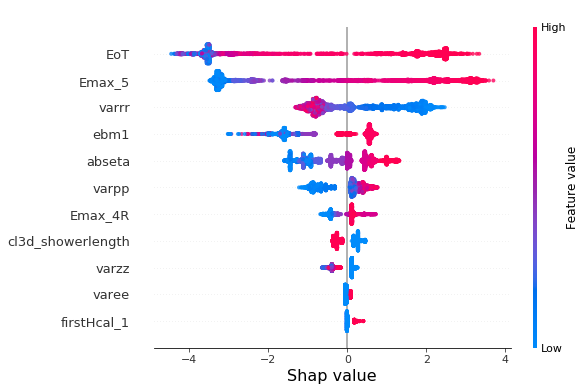

In [36]:
x=[  3.        ,   0.        ,   1.        ,   5.        ,
         3.        ,   9.        ,   0.        ,   1.        ,
         0.        ,   10.        ,  10.        ,   4.        ,
         3.        ,   0.        ,   1.        ,   0.        ]
out, pred, BDT, qtrain, feat_kept=train_quantized(x)
print(out)
plot_shap(BDT, qtrain, feat_kept)
#plt.savefig(res_dir+'/importance_violin.png', bbox_inches='tight')


In [37]:
import numpy as np

from pymoo.factory import get_algorithm, get_crossover, get_mutation, get_sampling, get_selection
from pymoo.optimize import minimize
from pymoo.model.problem import Problem


class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=nvar, n_obj=nobj, n_constr=nconstr, xl=xl, xu=xu, type_var=int, elementwise_evaluation=True)

    def _evaluate(self, x, out, *args, **kwargs):
        #define evaluations functions (minimization)
        #f1 = bkg eff at 99% signal efficiency
        #print(x)
        #it=pd.DataFrame([x], columns=features)
        #print(it)
        
        out["F"] = train_quantized(x)[0]
problem=MyProblem()

In [38]:
pd.options.mode.chained_assignment = None  # default='warn'    
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=DeprecationWarning)


#hyperdiagonal sampling:
#range=[0,12] (add if 13 -> no quantization?but then, how to quantify number of bits used?)
max_val=12
pop_size=60
sampling=[]
#hyperdiag
for i in range(1,max_val+1):
    sampling.append(np.full( problem.n_var, i))
sampling=np.array(sampling)
#add random init
"""for i in range(len(sampling), pop_size):

    sampling=np.append(sampling,[np.random.randint(0,12,problem.n_var)], axis=0)
    """


#sampling= get_sampling("int_random")


method = get_algorithm("nsga2",
                       pop_size=pop_size,
                       sampling=sampling,
                       crossover=get_crossover("int_sbx", prob=1.0, eta=3.0), #def 1,3
                       mutation=get_mutation("int_pm", eta=3.0), # def 3
                       eliminate_duplicates=True,
                       )


res = minimize(problem,
               method,
               termination=('n_gen', 40),
               seed=42,
               save_history=True,
               verbose=True
               )

print("Best solution found: %s" % res.X)
print("Function value: %s" % res.F)
print("Constraint violation: %s" % res.CV)

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      12 |       5 |            - |            -


divide by zero encountered in power
invalid value encountered in power


    2 |      72 |       9 |  0.454545455 |        nadir


divide by zero encountered in power
invalid value encountered in power


    3 |     132 |      10 |  0.333333333 |        nadir


invalid value encountered in power


    4 |     192 |      15 |  0.253164557 |        nadir


divide by zero encountered in power
invalid value encountered in power


    5 |     252 |      10 |  0.003750937 |        ideal


invalid value encountered in power


    6 |     312 |      11 |  0.075710153 |            f


invalid value encountered in power


    7 |     372 |      14 |  0.025405162 |        ideal


invalid value encountered in power


    8 |     432 |      14 |  0.073170732 |        ideal


invalid value encountered in power


    9 |     492 |      15 |  0.205882353 |        nadir


invalid value encountered in power


   10 |     552 |      17 |  0.028571429 |        ideal


invalid value encountered in power


   11 |     612 |      15 |  0.022282448 |            f


divide by zero encountered in power
invalid value encountered in power


   12 |     672 |      12 |  0.020354607 |            f


invalid value encountered in power


   13 |     732 |      14 |  0.027027027 |        ideal


invalid value encountered in power


   14 |     792 |      15 |  0.911102166 |        nadir


invalid value encountered in power


   15 |     852 |      16 |  0.567006014 |        nadir


invalid value encountered in power


   16 |     912 |      16 |  0.008767918 |            f


invalid value encountered in power


   17 |     972 |      16 |  0.019940898 |            f


invalid value encountered in power


   18 |    1032 |      18 |  0.046511628 |        ideal


invalid value encountered in power


   19 |    1092 |      19 |  0.012588311 |            f


invalid value encountered in power


   20 |    1152 |      20 |  0.022727273 |        ideal


invalid value encountered in power


   21 |    1212 |      20 |  0.022222222 |        ideal


invalid value encountered in power


   22 |    1272 |      18 |  0.333540100 |        nadir


invalid value encountered in power


   23 |    1332 |      19 |  0.021739130 |        ideal


invalid value encountered in power


   24 |    1392 |      19 |  0.007160774 |            f
   25 |    1452 |      21 |  0.007397689 |            f
   26 |    1512 |      24 |  0.021276596 |        ideal
   27 |    1572 |      25 |  0.010078770 |            f
   28 |    1632 |      24 |  0.020833333 |        ideal
   29 |    1692 |      25 |  5.000773149 |        nadir
   30 |    1752 |      24 |  0.020408163 |        ideal
   31 |    1812 |      24 |  0.492169123 |        nadir
   32 |    1872 |      25 |  0.001001447 |            f
   33 |    1932 |      22 |  0.256410256 |        nadir
   34 |    1992 |      21 |  0.032258065 |        ideal
   35 |    2052 |      23 |  0.005825536 |            f
   36 |    2112 |      24 |  0.002697030 |            f
   37 |    2172 |      24 |  0.000094160 |            f
   38 |    2232 |      22 |  0.002740290 |            f
   39 |    2292 |      23 |  0.001855385 |            f
   40 |    2352 |      25 |  0.004113549 |            f
Best solution found: [[1 1 0 1 1 4 3 1 1 1 0 1 1

In [39]:
moo_name= '40gen_diag_auc_mut10'

In [40]:
savedir

'/grid_mnt/vol_home/llr/cms/hakimi/HGCAL/moo/pions/'

In [41]:
import pickle as pkl
pkl.dump(res, open(savedir + '{}.pkl'.format(moo_name), 'wb'))

Text(0.5, 1.0, 'pareto front')

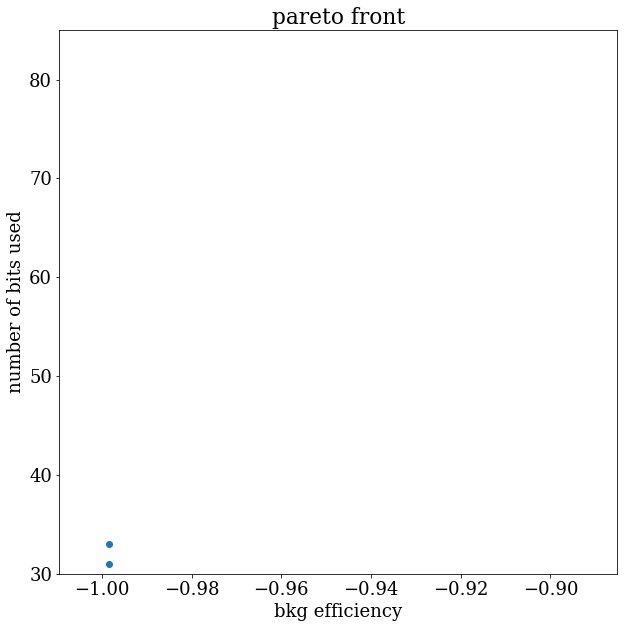

In [42]:
from pymoo.visualization.scatter import Scatter

Plot=Scatter(figsize=(10,10)).add(res.F).show()

#plt.vlines(x=f1, ymin=30, ymax= 85, label = "unquantized")
plt.ylim(30,85)
plt.xlabel('bkg efficiency')
plt.ylabel('number of bits used')
plt.title('pareto front')

In [43]:
res.history[0].pop.get("F")*(-1,1)

array([[  0.97590814,  16.        ],
       [  0.9954486 ,  32.        ],
       [  0.99748059,  48.        ],
       [  0.997633  ,  96.        ],
       [  0.99769211, 112.        ],
       [  0.99709673,  64.        ],
       [  0.99758125, 144.        ],
       [  0.99692695,  80.        ],
       [  0.99703564, 128.        ],
       [  0.99753561, 176.        ],
       [  0.99702522, 160.        ],
       [  0.99703925, 192.        ]])

In [44]:
len(res.history)

40

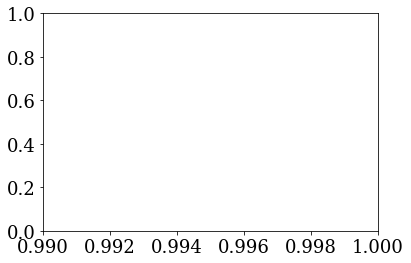

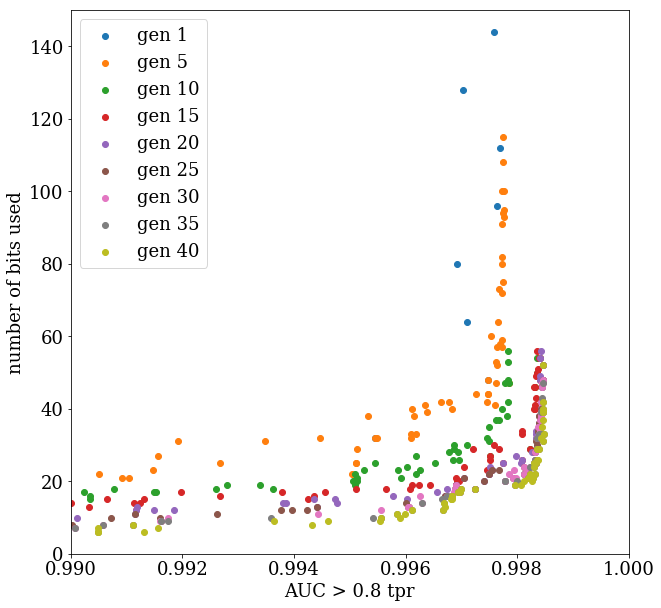

In [45]:
Plot=Scatter(figsize=(10,10))
if 'auc' in moo_name:
    coeff=(-1,1)
    title = 'AUC > 0.8 tpr'
    plt.xlim(0.99, 1)
else:
    coeff= (1,1)
    title= 'bkg eff at 0.99 signal efficiency'
Plot.add(res.history[0].pop.get("F")*coeff, label = 'gen {}'.format(1))
for i, hist in enumerate(res.history):
    if (i+1)%5==0:
        Plot.add(hist.pop.get("F")*coeff, label = 'gen {}'.format(i+1))
Plot.show()
#plt.vlines(x=f1, ymin=30, ymax= 170, label = "unquantized")
if 'auc' in moo_name:
    plt.xlim(0.99, 1.)
plt.ylim(0,150)

plt.xlabel(title)
plt.ylabel('number of bits used')
plt.legend()
plt.savefig(savedir + '{}.png'.format(moo_name))

In [46]:
a=[100*a for (a,b) in res.F]
b=[int(b) for (a,b) in res.F]

In [47]:
features

['abseta',
 'cl3d_firstlayer',
 'varee',
 'varpp',
 'varzz',
 'varrr',
 'cl3d_meanz',
 'cl3d_showerlength',
 'cl3d_coreshowerlength',
 'EoT',
 'Emax_5',
 'ebm1',
 'Emax_4R',
 'hbm',
 'firstHcal_1',
 'reverse_ebm1']

In [48]:
if bkg == 'QCD':
    feats= ['abseta',
 '1stlay',
 'vee',
 'vpp',
 'vzz',
 'vrr',
 'meanz',
 'sho_lgth',
 'coreshlgth',
 'EoT',
 'ebm1',
 'Emax_4R',
 'rev_ebm1',
 'first_2',
 'Emax_2R',
 'Emax_5']
elif bkg =='PU':
    feats = ['abseta', '1stlay', 'vee', 'vpp', 'vzz', 'vrr',
                 'meanz', 'sho_lgth','core_lgth', 'EoT',
                'firstH_5', 'Emax_4R', 'ebm1', 'Emax_2R', 'firstH_1', 'Emax_5']
elif bkg == 'pions':
    feats = ['abseta',
 '1stlay',
 'vee',
 'vpp',
 'vzz',
 'vrr',
 'meanz',
 'sho_lgth',
    'core_lgth',
 'EoT',
 'Emax_5',
 'ebm1',
 'Emax_4R',
 'hbm',
 'firstH_1',
 'rev_ebm1']

In [49]:
result= pd.DataFrame(res.X, columns=feats)
result['bkg_efficiency']=a
result['number of bits']=b

result.sort_values(["bkg_efficiency"])
result.to_csv(savedir + '{}_lastgen.csv'.format(moo_name))

In [55]:
result

,abseta,1stlay,vee,vpp,vzz,vrr,meanz,sho_lgth,core_lgth,EoT,Emax_5,ebm1,Emax_4R,hbm,firstH_1,rev_ebm1,bkg_efficiency,number of bits
0,1,1,0,1,1,4,3,1,1,1,0,1,1,1,0,1,-99.725387,18
1,0,1,0,6,1,6,1,0,1,4,2,1,1,1,0,0,-99.833772,25
2,1,2,1,1,1,4,0,0,1,2,0,1,1,1,0,1,-99.697493,17
3,0,0,1,3,1,6,3,0,1,7,0,5,1,1,0,0,-99.839195,29
4,1,1,0,0,1,4,0,0,1,0,0,1,1,1,0,1,-99.666983,12
5,0,1,0,9,1,7,4,0,2,4,0,1,1,1,0,0,-99.845670,31
6,0,1,0,9,1,7,4,0,1,4,0,2,1,1,0,2,-99.848428,33
7,0,1,0,3,1,6,1,0,1,4,2,1,1,0,0,1,-99.831254,22
8,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-89.615338,2
9,0,1,0,3,1,6,1,0,1,4,2,1,1,0,0,0,-99.828409,21


In [50]:
x=xu
qtrain=pd.DataFrame()
qtrain_uni=pd.DataFrame()
qtest=pd.DataFrame()
for i,feat in enumerate(X_train.columns):
    print("feature :", feat, "quantized on {} bits".format(x[i]))
    qtrain[feat]=quantize(X_train[feat], x[i], 'uniform', data[feat].min(), data[feat].max())
    #qtrain_uni[feat]=quantize(X_train[feat], x[i], 'uniform', data[feat].min(), data[feat].max())
    qtest[feat]=quantize(X_test[feat], x[i], 'uniform', data[feat].min(), data[feat].max())

train= xgb.DMatrix(data=X_train,label=y_train['signal'], feature_names=features)
test= xgb.DMatrix(data=X_test,label=y_test['signal'],feature_names=features)

#use gpu if available
gpu=tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)
if gpu==True:
    param['tree_method']='gpu_hist'

num_boost_round=200
es_rounds=3

metrics={'logloss','auc'} #last one used for es
# set up cross validation:
#print('beginning cv')
cv_results = xgb.cv(
    param,
    train,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics=metrics,
    #feval=SoverB,
    early_stopping_rounds=es_rounds,
    shuffle=True,
    verbose_eval=None
)

## we define best score as the best test_auc penalized by the gap between train and test auc
alpha=1 #(penalization)

best_score=(cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).max()
boost_rounds = (cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).argmax()
#Now train and fit best parameters BDT
eval_result = {}
BDT = xgb.train(
    param,
    train,
    num_boost_round=int(boost_rounds),
    #feval = SoverB,
    evals=[(train, 'Train'),(test, "Test")],
    evals_result = eval_result,
    verbose_eval=None,
)
pred= BDT.predict(test)
fpr, tpr, threshold = roc_curve(y_test['signal'],pred, pos_label=1)
fpr.sort()
tpr.sort()
roc_test=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})

#return bkg eff at 0.99 signal efficiency
f1=np.interp(0.99,roc_test['tpr'],roc_test['fpr'])

#f2 = total numer of bits used
f2=int(sum(x))
print('done')

feature : abseta quantized on 12 bits
feature : cl3d_firstlayer quantized on 5 bits
feature : varee quantized on 12 bits
feature : varpp quantized on 12 bits
feature : varzz quantized on 12 bits
feature : varrr quantized on 12 bits
feature : cl3d_meanz quantized on 12 bits
feature : cl3d_showerlength quantized on 6 bits
feature : cl3d_coreshowerlength quantized on 6 bits
feature : EoT quantized on 12 bits
feature : Emax_5 quantized on 12 bits
feature : ebm1 quantized on 10 bits
feature : Emax_4R quantized on 12 bits
feature : hbm quantized on 11 bits
feature : firstHcal_1 quantized on 12 bits
feature : reverse_ebm1 quantized on 10 bits
done


In [51]:
f1

0.016430171769977596

In [52]:
perc = 7.6%
uni = 2.9%

SyntaxError: invalid syntax (<ipython-input-52-3d254a89aa1d>, line 1)

In [ ]:
plt.figure(figsize=(10,10))
roc_auc_test = auc(fpr, tpr)
plt.plot(tpr,fpr, label =' AUC = {:2.2%}' .format(roc_auc_test))
plt.yscale('log')
plt.xlim(0.98,1.001)
plt.ylim(3e-2,5e-1)
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.title('BDT ROC curve (log)')
plt.grid()
plt.legend(loc='upper left')
print(f1)

In [ ]:
Counter((qtrain['cl3d_firstlayer']))

In [ ]:
Counter(y_test['signal'])

In [ ]:
feat=X_train['cl3d_firstlayer']
nbits=4
method='percentile'
fmin=data['cl3d_firstlayer'].min()
fmax=data['cl3d_firstlayer'].max()
print(fmin, fmax)
 #feat is the feature to quantize, nbist the number of bits, method: 'uniform' or 'percentile'
nbins= 2**nbits
if method == 'uniform':
    bins=np.linspace(fmin, fmax, nbins+1)
elif method == 'percentile':
    bins=[np.percentile(feat, n) for n in np.linspace(0,100,nbins+1)]
else :
    print('Error: Invalid method')

print(bins)

np.digitize(feat, bins)

In [ ]:
for i,feat in enumerate(features):
    print(feat)
    plt.figure(figsize=(10,6))
    bins= xu[i]
    plt.hist(qtrain_uni[feat][y_train['signal']==0], bins = bins, label='uniform')
    plt.hist(qtrain[feat][y_train['signal']==0],bins = bins, histtype='step', label = 'percentile)')
    plt.title(feat)
    plt.legend()
    

In [ ]:
qtrain_uni

In [ ]:
for i,feat in enumerate(X_train.columns):
    print(feat,X_train[feat].dtype)

In [ ]:
import pickle as pkl

result={}
for i,item in enumerate(os.listdir(savedir)):
    if "pkl" in item:
        print(i,savedir+item)
        result[i]=pkl.load(open(savedir+item, 'rb'))
        

i=1
feats= ['abseta',
 '1stlay',
 'vee',
 'vpp',
 'vzz',
 'vrr',
 'meanz',
 'sho_lgth',
 'coreshlgth',
 'EoT',
 'ebm1',
 'Emax_4R',
 'rev_ebm1',
 'first_2',
 'Emax_2R',
 'Emax_5']
a=[100*a for (a,b) in result[i].F]
b=[int(b) for (a,b) in result[i].F]
print(os.listdir(savedir)[i])
res_df= pd.DataFrame(result[i].X, columns=feats)
res_df['bkg_efficiency']=a
res_df['number of bits']=b
res_df.sort_values(["bkg_efficiency"])

In [ ]:
res_df.iloc[23]

In [ ]:
feats

In [ ]:
import plotly.graph_objects as go

In [ ]:
dimensions=[]
for ft in feats:
    tmp = dict(range=[0,10],
              #constraintrange = [0,12],
              label= ft,
              values= result[ft])
    dimensions.append(tmp)
    

In [ ]:
result

In [ ]:
fig = go.Figure(data = 
               go.Parcoords(
                    line = dict(color = result['bkg_efficiency']*(-1),
                            colorscale = 'Bluered',
                            showscale =True,
                            cmin = 99,
                            cmax=100
                               ),
                    dimensions = dimensions
                              
                              
                           )
               )
fig.show()
fig.write_image(savedir + '{}_par.png'.format(moo_name))

In [ ]:
os.makedirs(savedir + 'feats', exist_ok=True)
for ft in feats:
    plt.figure(figsize=(10,8))
    plt.scatter(result['bkg_efficiency'].values*(-1), result['number of bits'], c= result[ft])
    #plt.ylim(0,85)
    plt.colorbar()
    plt.xlabel('bkg efficiency')
    plt.ylabel('number of bits used')
    plt.title(ft)
    plt.savefig(savedir+ '/feats/{}.png'.format(ft))
    

In [ ]:
result[['bkg_efficiency', 'number of bits']].values

In [ ]:
plt.scatter(result['bkg_efficiency'].values* (-1), result['number of bits'], c= result[ft])